In [2]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]


In [3]:
coco = COCO('../../dataset/val_data_fold_3_seed_411.json')
# coco = COCO('../dataset/train_rm_outlier_40_fold_3_seed_411_real.json')
df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

df['image_id'] = image_ids
df['classname'] = class_name
df['category_id'] = class_id
df['xmin'] = x_min
df['ymin'] = y_min
df['xmax'] = x_max
df['ymax'] = y_max

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [4]:
df

,image_id,classname,category_id,xmin,ymin,xmax,ymax
0,train/0000.jpg,General trash,0,197.6,193.7,745.4,663.4
1,train/0003.jpg,Paper pack,2,462.2,369.4,696.1,624.0
2,train/0003.jpg,Styrofoam,6,773.3,3.0,961.7,431.4
3,train/0015.jpg,Styrofoam,6,844.2,499.5,892.5,600.7
4,train/0015.jpg,Metal,3,423.9,390.4,848.0,717.8
...,...,...,...,...,...,...,...
4685,train/4870.jpg,Paper,1,251.6,339.6,689.8,736.6
4686,train/4881.jpg,Plastic bag,7,114.5,45.2,866.2,518.1
4687,train/4881.jpg,Plastic bag,7,724.0,69.1,769.0,111.8
4688,train/4881.jpg,Paper,1,279.0,459.7,443.6,567.9


{0: 774, 1: 1283, 2: 182, 3: 187, 4: 203, 5: 613, 6: 250, 7: 1046, 8: 43, 9: 109}


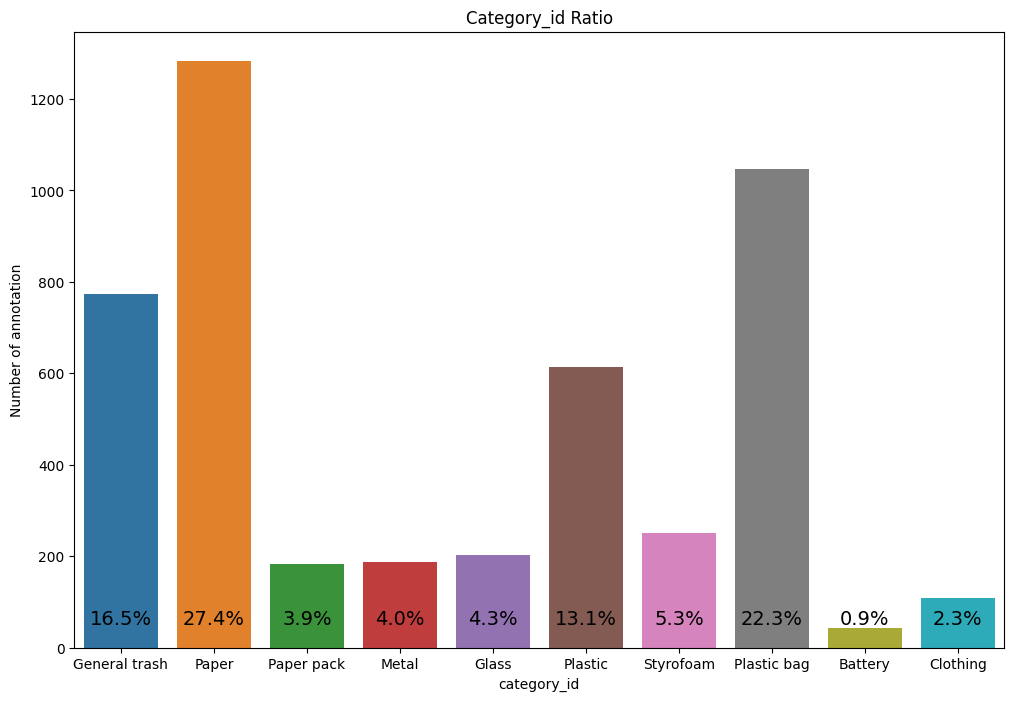

In [5]:
plt.figure(figsize = (12,8))

ax = sns.countplot(x ='category_id', data=df)

plt.title("Category_id Ratio")
plt.ylabel("Number of annotation")
plt.xticks(range(len(classes)),classes)
count = df['category_id'].value_counts()
count = dict(sorted(count.items()))
counts = [f'{elem/sum(count.values()) * 100:.1f}%' for elem in count.values()]
print(count)
for i,v in enumerate(counts):
    ax.text(i,50,v,horizontalalignment='center', size= 14, color="black")

plt.show()

image_id
train/0000.jpg     1
train/0003.jpg     2
train/0015.jpg     3
train/0018.jpg    11
train/0019.jpg    10
                  ..
train/4844.jpg     1
train/4853.jpg     1
train/4866.jpg     8
train/4870.jpg     1
train/4881.jpg     4
Name: category_id, Length: 981, dtype: int64
1-10     861
11-20     85
21-30     23
31-40      7
41-50      4
61-72      1
51-60      0
Name: category_id, dtype: int64
1-10     0.877676
11-20    0.086646
21-30    0.023445
31-40    0.007136
41-50    0.004077
61-72    0.001019
51-60    0.000000
Name: category_id, dtype: float64


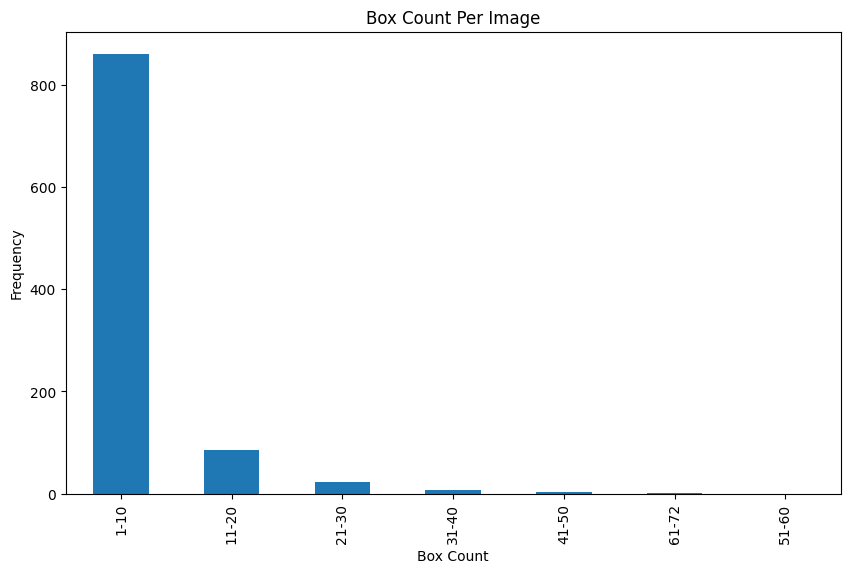

In [6]:
 # 각 이미지의 박스 개수 계산
box_counts = df.groupby('image_id')['category_id'].count()
print(box_counts)

# 범위를 지정하여 데이터 분할
bins = [0, 10, 20, 30, 40, 50, 60, 72]
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-72']
box_ranges = pd.cut(box_counts, bins=bins, labels=labels)

# 각 범위별 데이터 수 계산
range_counts = box_ranges.value_counts()

# 비율 계산
range_ratios = range_counts / range_counts.sum()
print(range_counts)
print(range_ratios)

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
range_counts.plot(kind='bar')
plt.xlabel('Box Count')
plt.ylabel('Frequency')
plt.title('Box Count Per Image')

plt.show()


['train/0123.jpg', 'train/0602.jpg', 'train/0903.jpg', 'train/0949.jpg', 'train/1061.jpg', 'train/1816.jpg', 'train/1913.jpg', 'train/2539.jpg', 'train/2616.jpg', 'train/2666.jpg', 'train/2948.jpg', 'train/3113.jpg', 'train/3575.jpg']


FileNotFoundError: [Errno 2] No such file or directory: '../dataset_EDA/21~25/train/0123.jpg'

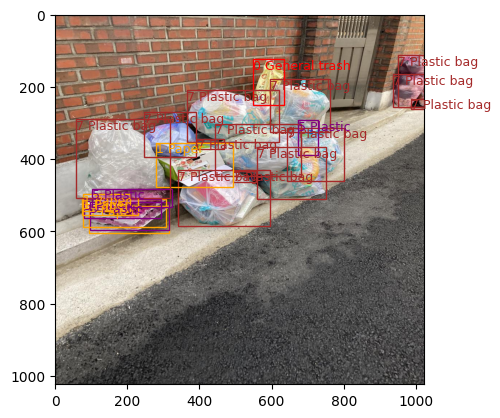

In [7]:
## 이미지 저장 / bbox 개수 별로 따로 저장
from matplotlib.patches import Rectangle

data_dir = '../../dataset/' 
colors = ['red', 'orange', 'yellow', 'green',  'blue', 'purple',  'pink', 'brown', 'gray', 'black']
filenames_outlier = box_counts.loc[(box_counts > 20) & (box_counts <= 25)].index.tolist() #
print(filenames_outlier)
n = 0
for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']
    
    if filename in filenames_outlier : 
        n+=1
        plt.clf()
        # 이미지 경로 가져오기
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(data_dir, filename)
        # 이미지 출력
        img = Image.open(img_path)
        plt.imshow(img)

        # bbox 출력
        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            bbox = ann['bbox']
            x, y, w, h = bbox
            label_id = ann['category_id']
            rect = Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[label_id], facecolor='none')
            plt.gca().add_patch(rect)

                # 라벨 출력
            label_name = f'{label_id} {classes[label_id]}'
            plt.text(x, y, label_name, fontsize=9, color=colors[label_id], verticalalignment='top')

        plt.savefig(f'../dataset_EDA/21~25/{filename}')

print(n)


In [11]:
## Outlier 제거 
coco = COCO('../../dataset/train_data_fold_3_seed_411.json')
annotation = '../../dataset/train_data_fold_3_seed_411.json'
# coco = COCO('../dataset_EDA/train_rm_outlier_20.json')
df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

df['image_id'] = image_ids
df['classname'] = class_name
df['category_id'] = class_id
df['xmin'] = x_min
df['ymin'] = y_min
df['xmax'] = x_max
df['ymax'] = y_max

import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
seed = 411

with open(annotation) as f: data = json.load(f)

box_counts = df.groupby('image_id')['category_id'].count()
filenames_outlier = box_counts.loc[box_counts > 40].index.tolist() #(box_counts > 30) & (box_counts <= 40)
print(filenames_outlier)

images = data['images']
annotations = data['annotations']


train_images = [x for x in images if not x.get('file_name') in filenames_outlier]
trian_annos = [x for x in annotations if not x.get('file_name') in filenames_outlier]

train_data = {
    'info' : data['info'],
    'licenses' : data['licenses'],
    'images' : train_images,
    'categories' : data['categories'],
    'annotations' : trian_annos
                    }
with open(f'../../dataset_EDA/train_rm_outlier_40_fold_3_seed_411_real_.json', 'w') as f:
    json.dump(train_data, f, indent=4)
print('completed')


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
['train/0394.jpg', 'train/0946.jpg', 'train/1678.jpg', 'train/1797.jpg', 'train/1955.jpg', 'train/4047.jpg']
completed


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


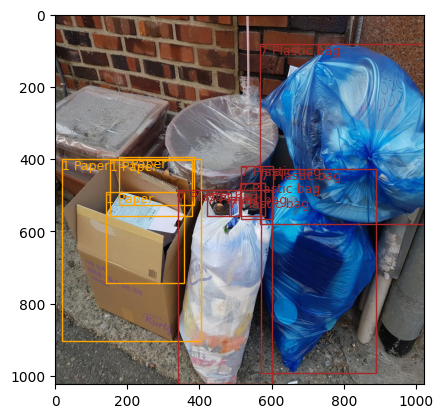

In [14]:
## 이미지  idx로 한장 출력
# 이미지 ID 지정
coco = COCO('../../dataset/train.json')
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]


colors = ['red', 'orange', 'yellow', 'green',  'blue', 'purple',  'pink', 'brown', 'gray', 'black']

LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

from matplotlib.patches import Rectangle
img_id = 3000
data_dir = '../../dataset/'

# 이미지 경로 가져오기
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(data_dir,  img_info['file_name'])

# 이미지 출력
img = Image.open(img_path)
plt.imshow(img)

# bbox 출력
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = bbox
    label_id = ann['category_id']
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[label_id], facecolor='none')
    plt.gca().add_patch(rect)

        # 라벨 출력
    label_name = f'{label_id} {classes[label_id]}'
    plt.text(x, y, label_name, fontsize=9, color=colors[label_id], verticalalignment='top')


plt.show()

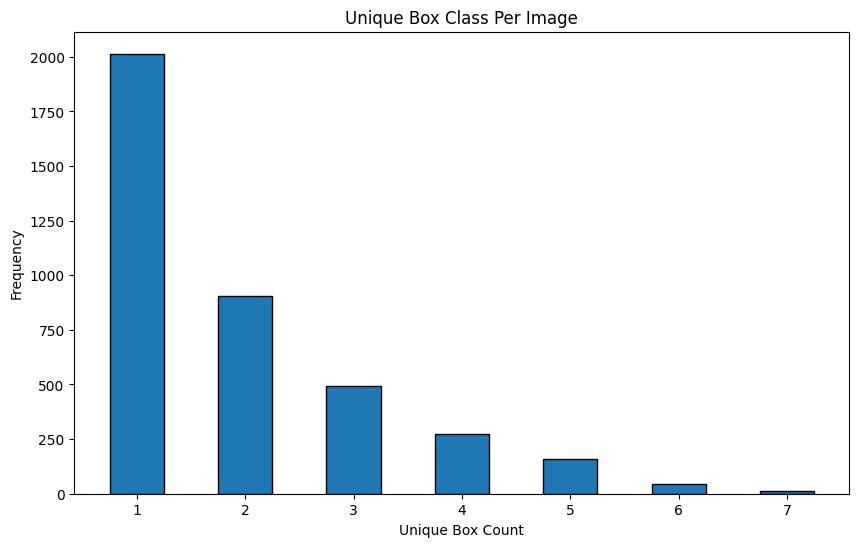

In [15]:
unique_box = df.groupby('image_id')['category_id'].nunique()

plt.figure(figsize=(10, 6))
plt.hist(unique_box, bins=range(1, unique_box.max()+2), edgecolor='black',rwidth=0.5, align='left')
plt.xlabel('Unique Box Count')
plt.ylabel('Frequency')
plt.title('Unique Box Class Per Image')



plt.show()